In [160]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import os
from FilesFunc import files
folders = ["Background", "BH", "Sphaleron"]
stuffs = ["electron", "jet", "MET", "muon", "photon", "tau"]
data_variables = ["HT", "met", "phi_diff", "ptmax", "stuff_amount"]
file_amounts = [0, 18, 3]
font = {'family': 'Times New Roman',
        'color':  'black',
        'weight': 'normal'
        }


filenames_dict = {
    "PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL": "Sphal1",
    "PP13-Sphaleron-THR9-FRZ15-NB33-60-NSUBP50": "Sphal2",
    "PP13-Sphaleron-THR9-FRZ15-NB33-71-NSUBP5": "Sphal3",
    "BH_n4_M8": "BH1",
    "BH_n4_M9": "BH2",
    "BH_n4_M9_Mpl9": "BH3",
    "BH_n4_M10": "BH4",
    "BH_n4_M11": "BH5",
    "BH_n4_M12": "BH6",
    "BH_n5_M8": "BH7",
    "BH_n5_M9": "BH8",
    "BH_n5_M10": "BH9",
    "BH_n5_M11": "BH10",
    "BH_n5_M12": "BH11",
    "BH_n6_M8": "BH12",
    "BH_n6_M9": "BH13",
    "BH_n6_M10": "BH14",
    "BH_n6_M11": "BH15",
    "BH_n6_M12": "BH16",
    "BlackMaxOutputFirstRun1": "BH17",
    "BlackMaxOutputFirstRun2": "BH18",
    "ttbar_largejet": "ttbar1",
    "ttbar": "ttbar2"
}


def work_space(path):
    while True:
        if os.path.split(path)[1] != "Programs":
            path = os.path.split(path)[0]
        else:
            return path.replace("\\", "/")
work_dir = work_space(os.getcwd())


def remover(old_list, index):
    new_list = [element for element_index, element in enumerate(old_list) if element_index != index]
    return new_list


def unpacker(folder_data, new_folder_data):
    for nested_list in folder_data:
        if type(nested_list) == list:
            unpacker(nested_list, new_folder_data)
        else:
            new_folder_data.append(nested_list)
    folder_data = new_folder_data
    return folder_data


def dropper(dataframe, data_variables):
    to_drop = [col for col in dataframe.columns if col not in data_variables]
    dataframe = dataframe.drop(to_drop, axis = 1)
    return dataframe


def dataframe_retriever(data_path, data_variables):
    from natsort import natsorted, ns
    folders = os.listdir(data_path)
    folder_filenames = [natsorted([filename for filename in os.listdir(data_path + folder)], key = lambda y: y.lower()) for folder in folders]
    folder_filepaths = [[data_path + folder + "/" + filename for filename in folder_filenames[folder_index]] for folder_index, folder in enumerate(folders)]
    folder_filenames = [[filenames_dict[filename[:-len(".csv")]] for filename in filenames] for filenames in folder_filenames]
    dataframes = [[(pd.read_csv(filepath).drop("Unnamed: 0", axis = 1), filename) for filepath, filename in zip(filepaths, filenames)] for filepaths, filenames in zip(folder_filepaths, folder_filenames)]
    return dataframes


def sampler(model_dataframes, file_amounts, data_variables, strings):
    from random import sample
    dataframe_tuples = []
    for file_amount, dataframes in zip(file_amounts, model_dataframes):
        dataframe_tuples.append(sample(dataframes, file_amount)) if type(file_amount) == int else dataframe_tuples.append([dataframe for dataframe in dataframes if dataframe[1] in file_amount])
    dataframe_tuples = [sorted(dataframes, key = lambda x: int(x[1][len(string):])) for dataframes, string in zip(dataframe_tuples, strings)]
    for folder_index, file_amount in enumerate(file_amounts):
        if file_amount == 0:
            dataframe_tuples = remover(dataframe_tuples, folder_index)
    
    
    foldered_filenames = [[dataframe[1] for dataframe in dataframes] for dataframes in dataframe_tuples]
    foldered_dataframes = [[dropper(dataframe[0], data_variables) for dataframe in dataframes] for dataframes in dataframe_tuples]

    return foldered_dataframes, foldered_filenames

In [161]:
def efficiencies_data(efficiency_data, binsize):
    bh_data, sphal_data = efficiency_data
    x_bh, y_bh = data_binner(bh_data, binsize, plot = False)
    x_sphal, y_sphal = data_binner(sphal_data, binsize, plot = False)
    x_interval = np.concatenate((x_bh, x_sphal))
    x_min, x_max = np.min(x_interval), np.max(x_interval)
    bins = int(np.round((x_max - x_min)/binsize))
    total_efficiencies = []

    for bin in range(bins + 1):
        bh_left = y_bh[:bin + 1]
        bh_right = y_bh[bin + 1:]
        bh_split = [bh_left, bh_right]
        
        sphal_left = y_sphal[:bin + 1]
        sphal_right = y_sphal[bin + 1:]
        sphal_split = [sphal_right, sphal_left]

        temp_efficiency = []
        for i in range(len(["left", "right"])):
            bh_efficiency = np.sum(bh_split[i])
            sphal_efficiency = np.sum(sphal_split[i])
            total_efficiency = bh_efficiency + sphal_efficiency
            if i == 0:
                temp_efficiency.append((total_efficiency, 0))
            else:
                temp_efficiency.append((total_efficiency, 1))


        total_efficiencies.append((*sorted(temp_efficiency, key = lambda x: x[0])[-1], bin))
    
    max_efficiency = sorted(total_efficiencies, key = lambda x: x[0])[-1]
    me_value = max_efficiency[0] / 2
    me_dir = max_efficiency[1]
    me_bin = max_efficiency[2]
    me_x = x_min + me_bin * binsize
    
    return [me_x, me_value, me_dir]


def data_binner(data, binsize, plot):
    data = unpacker(data, [])

    if len(data) == 0:
        x = [bin * binsize for bin in range(200)]
        y = [0 for bin in range(200)]
        return x, y

    max_value = np.max(data)
    bins = int(np.round(max_value / binsize))
    bins = np.arange(0, bins)
    data = np.array(data)
    x, y = [], []

    if plot:
        for bin in range(len(bins)):
            temp = data
            temp = temp[temp <= (bin + 1/2)*binsize]
            temp = temp[(bin - 1/2)*binsize < temp]
            if len(temp) != 0:
                y.append(len(temp))
                x.append(bin*binsize)

        y = y/np.sum(y)

        return x, y
    else:
        for bin in range(len(bins)):
            temp = data
            temp = temp[temp <= (bin + 1/2)*binsize]
            temp = temp[(bin - 1/2)*binsize < temp]
            y.append(len(temp))
            x.append(bin*binsize)

        y = y/np.sum(y)

        return x, y


def eff_tuper(tree_dataframes, variables, binsizes):
    black_hole_data, sphaleron_data = tree_dataframes
    combined_bh = pd.concat(black_hole_data)
    combined_sphal = pd.concat(sphaleron_data)
    eff_tupes = []

    for variable, binsize in zip(variables, binsizes):
        efficiency_data = (combined_bh[variable], combined_sphal[variable])
        eff_x, eff_value, eff_dir = efficiencies_data(efficiency_data, binsize)
        eff_tupes.append((eff_x, eff_value, eff_dir))
        print(variable, eff_x, eff_value, eff_dir)

    # 0 => BH < Sphal, 1 => BH > Sphal
    return eff_tupes


def evaluator(tree_dataframes, tree_filenames, variables, binsizes, eff_tupes):
    black_hole_data, sphaleron_data = tree_dataframes
    sample_num = np.min([len(dataframe.iloc[:]) for dataframe in unpacker(tree_dataframes, [])])
    black_hole_data = [dataframe.sample(n = sample_num) for dataframe in black_hole_data]
    sphaleron_data = [dataframe.sample(n = sample_num) for dataframe in sphaleron_data]

    black_hole_guesses = [[0 for category in tree_dataframes] for datafile in black_hole_data]
    for datafile_index, bh_df in enumerate(black_hole_data):
        for event_index in range(len(bh_df.iloc[:])):
            event = bh_df.iloc[event_index]
            results = []
            for variable, eff_tupe in zip(variables, eff_tupes):
                eff_x, eff_value, eff_dir = eff_tupe
                if event[variable] <= eff_x and eff_dir == 0 or event[variable] > eff_x and eff_dir == 1:
                    results.append(True)
                else:
                    results.append(False)
            if results.count(True) > len(results) / 2:
                black_hole_guesses[datafile_index][0] += 1
            else:
                black_hole_guesses[datafile_index][1] += 1

    sphaleron_guesses = [[0 for category in tree_dataframes] for datafile in sphaleron_data]
    for datafile_index, sphal_df in enumerate(sphaleron_data):
        for event_index in range(len(sphal_df.iloc[:])):
            event = sphal_df.iloc[event_index]
            results = []
            for variable, eff_tupe in zip(variables, eff_tupes):
                eff_x, eff_value, eff_dir = eff_tupe
                if event[variable] > eff_x and eff_dir == 0 or event[variable] < eff_x and eff_dir == 1:
                    results.append(True)
                else:
                    results.append(False)
            if results.count(True) > len(results) / 2:
                sphaleron_guesses[datafile_index][1] += 1
            else:
                sphaleron_guesses[datafile_index][0] += 1
    
    bh_guesses = np.array(black_hole_guesses)
    sphal_guesses = np.array(sphaleron_guesses)
    guesses = np.concatenate((bh_guesses, sphal_guesses))

    filenames = np.concatenate(tree_filenames)

    return guesses, filenames

In [162]:
data_path = work_dir + "/Hub/VariableData/"
folder_dataframes = dataframe_retriever(data_path, data_variables)

combine_data = True
combine = [True, True, True]
file_amounts = [2, ["BH6", "BH11", "BH16"], ["Sphal1"]]
strings = ["ttbar", "BH", "Sphal"]

if not combine_data:
    try:
        remove_index = folders.index("Background")
        folders = remover(folders, remove_index)
        folder_dataframes = remover(folder_dataframes, remove_index)
        combine = remover(combine, remove_index)
        file_amounts = remover(file_amounts, remove_index)
        strings = remover(strings, remove_index)
    except:
        pass

In [163]:
# data_variables = ["HT", "met", "phi_diff", "ptmax"]

file_amounts = [0, ["BH6", "BH11", "BH16"], ["Sphal1"]]
tree_dataframes, tree_filenames = sampler(folder_dataframes, file_amounts, data_variables, strings)
eff_tupes = eff_tuper(tree_dataframes, data_variables, binsizes = [1, 1, 0.01, 1, 0.5])


file_amounts = [0, 18, 3]
guess_dataframes, guess_filenames = sampler(folder_dataframes, file_amounts, data_variables, strings)
guesses, ylabels = evaluator(guess_dataframes, guess_filenames, data_variables, binsizes = [1, 1, 0.01, 1, 0.5], eff_tupes = eff_tupes)
print(guesses)
xlabels = unpacker([folders[folder_index] if condition else filenames for folder_index, (filenames, condition) in enumerate(zip(guess_filenames, combine))], [])

HT 7756 0.8422282662853324 1
met 423 0.586750895081896 0
phi_diff 0.0 0.5419787220814178 1
ptmax 2153 0.853063729264868 1
stuff_amount 10.5 0.7810936793773757 0
[[611 389]
 [660 340]
 [837 163]
 [728 272]
 [786 214]
 [820 180]
 [630 370]
 [658 342]
 [753 247]
 [791 209]
 [856 144]
 [649 351]
 [686 314]
 [756 244]
 [820 180]
 [834 166]
 [641 359]
 [652 348]
 [ 85 915]
 [150 850]
 [  7 993]]


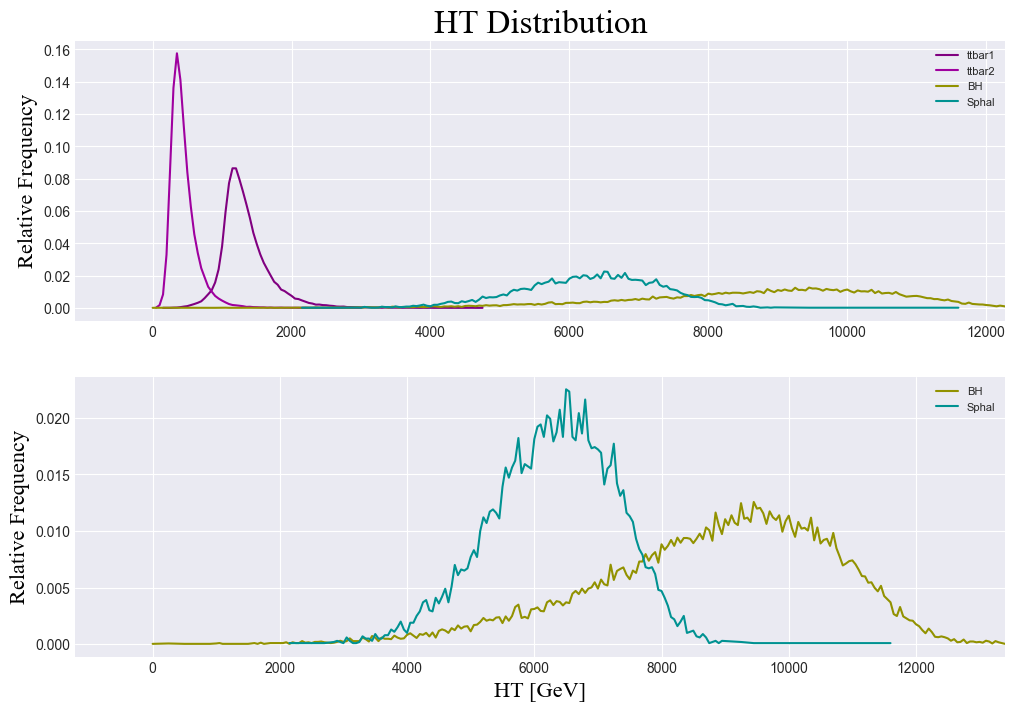

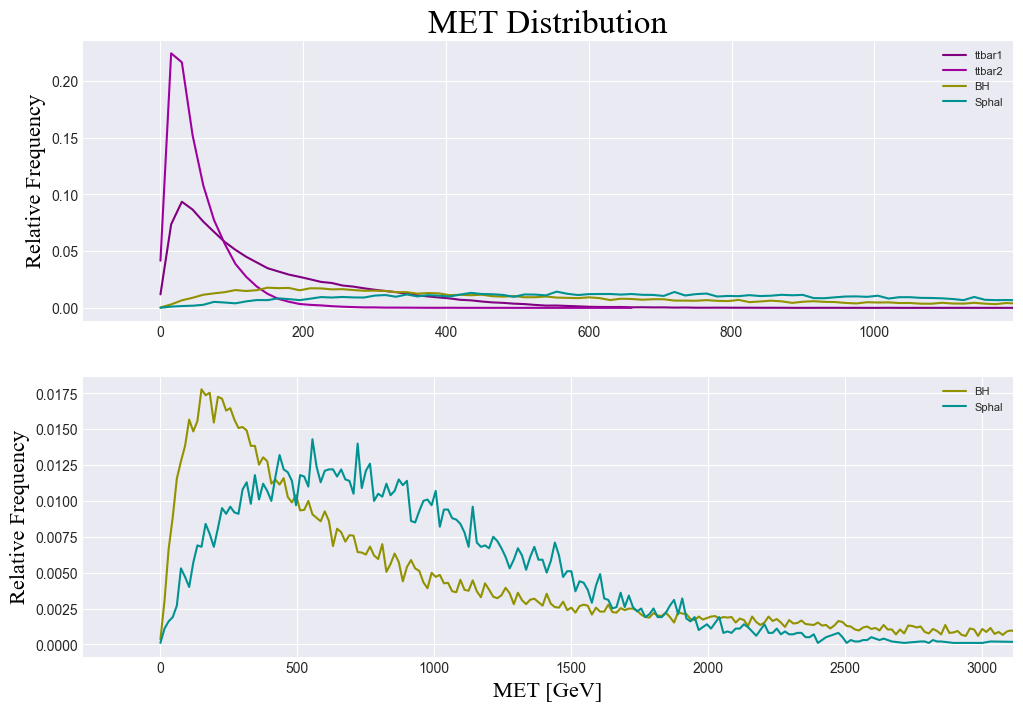

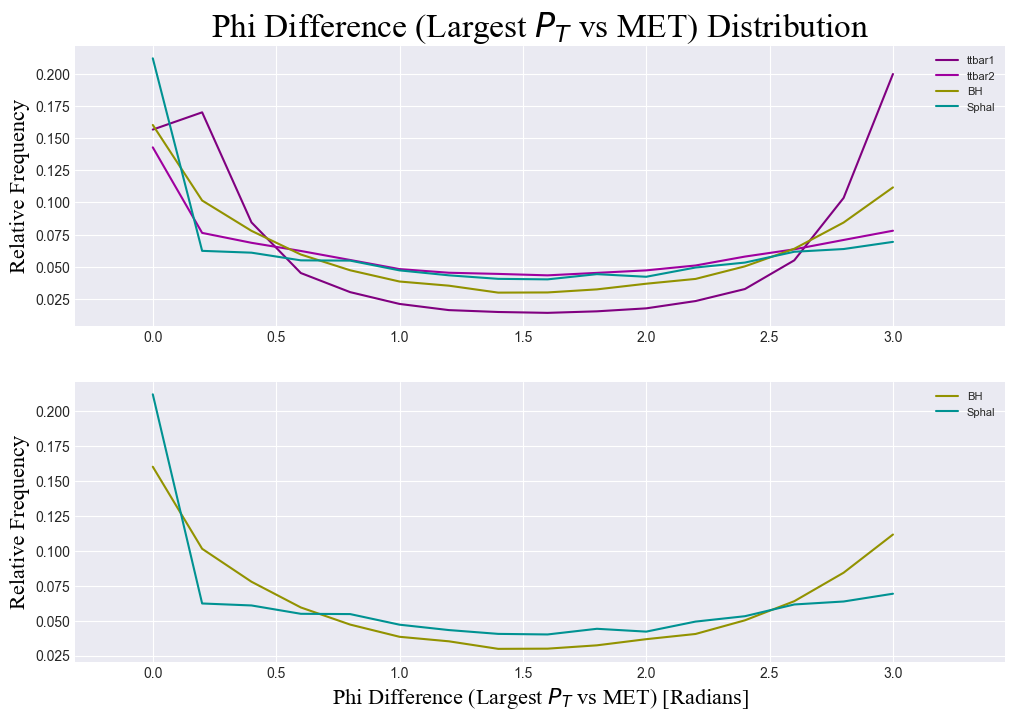

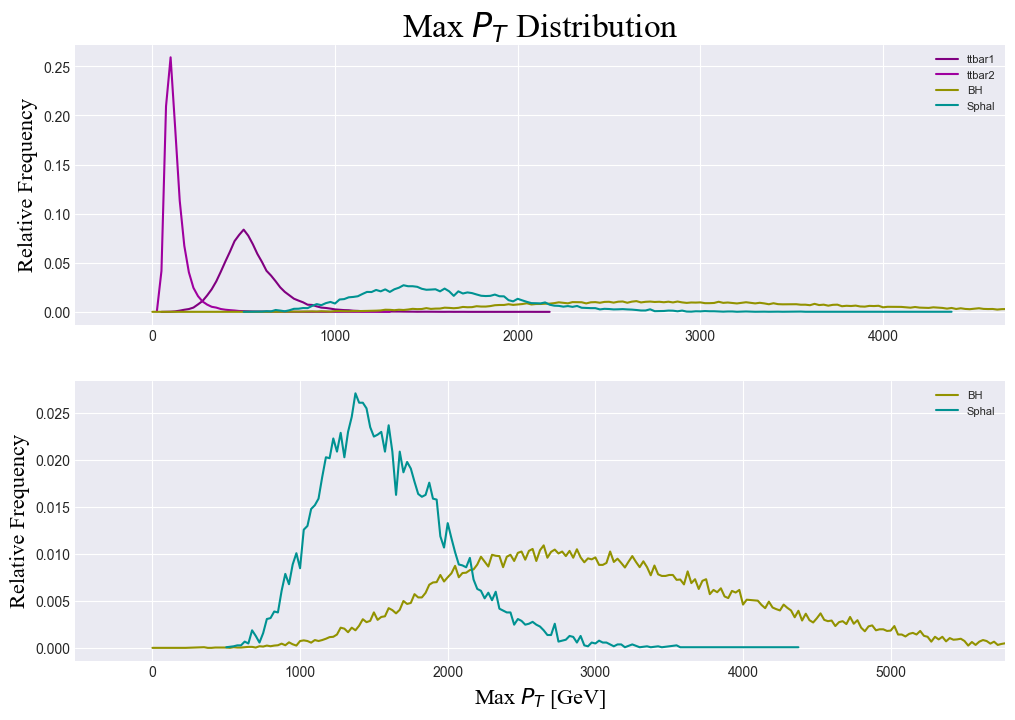

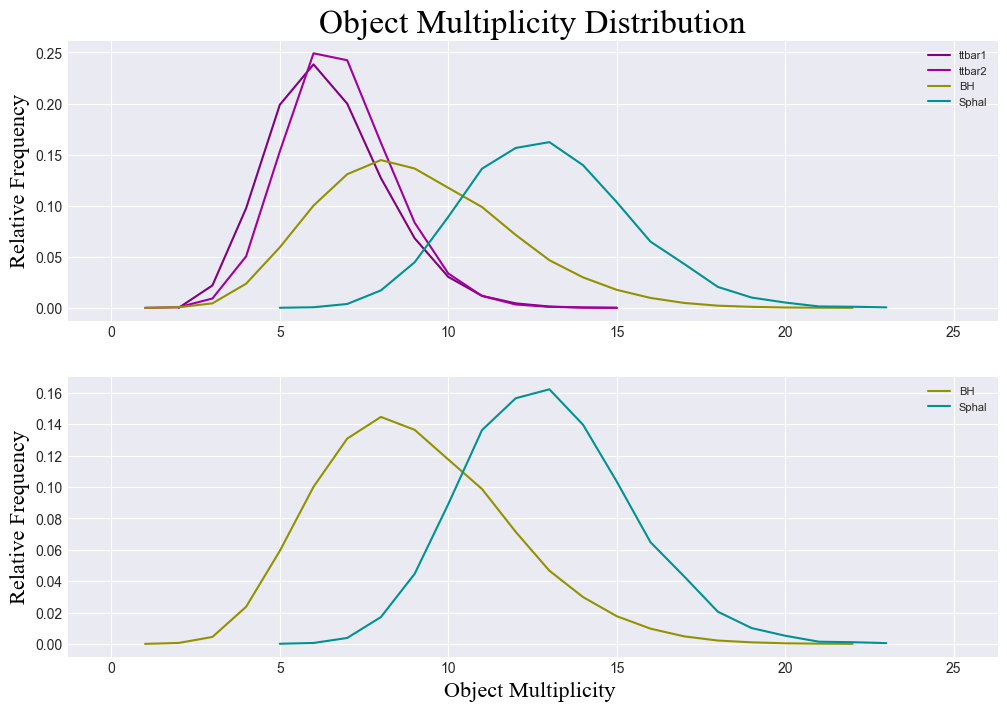

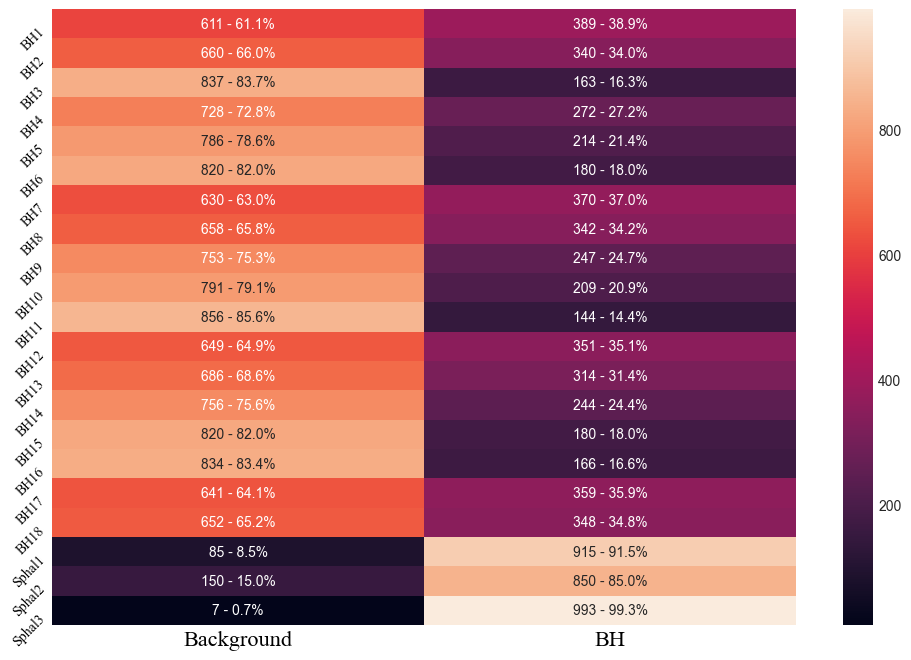

In [165]:
def heatmap_labels(guesses):
    y_pred_data = guesses
    y_pred_labels = [tuple(str(guess[i]) + " - " + str(np.round(guess[i] * 100 / np.sum(guess), 1)) + "%" for i in range(len(remover(folders, 0)))) for guess in guesses]

    return y_pred_data, y_pred_labels



if True:
    file_amounts = [2, ["BH6", "BH11", "BH16"], ["Sphal1"]]
    plotting_dataframes, plotting_filenames = sampler(folder_dataframes, file_amounts, data_variables, strings)
    background_data, black_hole_data, sphaleron_data = plotting_dataframes

    combined_bh = pd.concat(black_hole_data)
    combined_sphal = pd.concat(sphaleron_data)
    plotting_dataframes = [background_data, combined_bh, combined_sphal]
    temp_amounts = [2, 1, 1]
    colors = []
    for index, file_amount in enumerate(temp_amounts):
        temp_list = []
        for amount in range(1, 1 + file_amount):
            rgb = [0, 0, 0]
            rgb[index] = (amount + 3) * 1 / (file_amount + 6)
            rgb[int((index + 2) % 3)] = (amount + 3) * 1 / (file_amount + 6)
            temp_list.append(rgb)
        colors.append(temp_list) 

    from Plotter import plotter
    figsize = 8
    plotter(data_variables, plotting_dataframes, [plotting_filenames[0], "BH", "Sphal"], colors, filter_strengths = [0.99, 0.95, 1, 0.985, 1], binsizes = [50, 15, 0.2, 25, 0.5], figsize = figsize)


if True:
    y_pred_data, y_pred_labels = heatmap_labels(guesses)


    fig = plt.figure(figsize = (12, 8))
    plt.style.use("seaborn-v0_8-dark")
    axs = fig.subplots(1, 1)


    x_ticks = np.arange(len(xlabels))   
    y_ticks = np.arange(len(ylabels))    

    import seaborn as sns

    # Plot confusion matrix
    ax = axs
    sns.heatmap(y_pred_data, annot = y_pred_labels, fmt = "", ax = ax, xticklabels = xlabels, yticklabels = ylabels)
    ax.set_yticklabels(ax.get_yticklabels(), va = "top", rotation = 45, fontdict = font)
    ax.set_xticklabels(ax.get_xticklabels(), fontdict = font, fontsize = 16)